In [65]:
import pandas as pd
import kagglehub
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler

#Download Dataset
path = kagglehub.dataset_download("radheshyamkollipara/bank-customer-churn")

## Data cleaning

In [66]:
# Loading Data
data = pd.read_csv(f"{path}/Customer-Churn-Records.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   RowNumber           10000 non-null  int64  
 1   CustomerId          10000 non-null  int64  
 2   Surname             10000 non-null  object 
 3   CreditScore         10000 non-null  int64  
 4   Geography           10000 non-null  object 
 5   Gender              10000 non-null  object 
 6   Age                 10000 non-null  int64  
 7   Tenure              10000 non-null  int64  
 8   Balance             10000 non-null  float64
 9   NumOfProducts       10000 non-null  int64  
 10  HasCrCard           10000 non-null  int64  
 11  IsActiveMember      10000 non-null  int64  
 12  EstimatedSalary     10000 non-null  float64
 13  Exited              10000 non-null  int64  
 14  Complain            10000 non-null  int64  
 15  Satisfaction Score  10000 non-null  int64  
 16  Card 

In [67]:
df = data.drop(columns=['RowNumber', 'CustomerId','Surname', 'Complain'])
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Satisfaction Score,Card Type,Point Earned
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,2,DIAMOND,464
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,3,DIAMOND,456
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,3,DIAMOND,377
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,5,GOLD,350
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,5,GOLD,425


In [68]:
card_types = {'DIAMOND': 4, 'PLATINUM': 3, 'GOLD': 2, 'SILVER': 1}
gender_types = {'Female': 1, 'Male': 0}

df['Card Type'] = df['Card Type'].map(card_types)
df['Gender'] = df['Gender'].map(gender_types)

df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Satisfaction Score,Card Type,Point Earned
0,619,France,1,42,2,0.00,1,1,1,101348.88,1,2,4,464
1,608,Spain,1,41,1,83807.86,1,0,1,112542.58,0,3,4,456
2,502,France,1,42,8,159660.80,3,1,0,113931.57,1,3,4,377
3,699,France,1,39,1,0.00,2,0,0,93826.63,0,5,2,350
4,850,Spain,1,43,2,125510.82,1,1,1,79084.10,0,5,2,425


In [69]:
#Get dummies encoding
dummies = pd.get_dummies(df['Geography'], prefix='Geography')

df = pd.concat([df, dummies], axis=1)
df = df.drop(columns=['Geography'])
df.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Satisfaction Score,Card Type,Point Earned,Geography_France,Geography_Germany,Geography_Spain
0,619,1,42,2,0.00,1,1,1,101348.88,1,2,4,464,True,False,False
1,608,1,41,1,83807.86,1,0,1,112542.58,0,3,4,456,False,False,True
2,502,1,42,8,159660.80,3,1,0,113931.57,1,3,4,377,True,False,False
3,699,1,39,1,0.00,2,0,0,93826.63,0,5,2,350,True,False,False
4,850,1,43,2,125510.82,1,1,1,79084.10,0,5,2,425,False,False,True


## Machine Learning

In [70]:
training_data = df.drop(columns=['Exited'])
testing_data = df['Exited']
X_train, X_test, Y_train, Y_test = train_test_split(training_data, testing_data, test_size=0.20, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

cv = KFold(n_splits=5, shuffle=True, random_state=42)

def crossValidate(model, param_grid):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring='roc_auc')
    grid_search.fit(X_train, Y_train)
    
    return grid_search.best_score_, grid_search.best_params_


In [77]:
#hyperparameters
param_grid_lr = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 0.5, 1, 10, 20],
    'solver': ['liblinear']
}
param_grid_knn = {
    'n_neighbors': list(range(5, 105, 5)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
param_grid_dt = {
    'max_depth': [10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'criterion': ['gini', 'entropy']
}
param_grid_xgb = {
    'max_depth': [2, 4, 6, 8, 10],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
}
param_grid_rf = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [10, 20, 30, None],
}

In [72]:
lr_model = LogisticRegression(max_iter=10000)
auc_lr, best_params_lr = crossValidate(lr_model, param_grid_lr)

print(f"LogisticRegression AUC = {auc_lr}")
print(f"Best parameters found: {best_params_lr}")

LogisticRegression AUC = 0.7631480014861524
Best parameters found: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}


In [73]:
knn_model = KNeighborsClassifier()
auc_knn, best_params_knn = crossValidate(knn_model, param_grid_knn)
  
print(f"KNeighbors AUC = {auc_knn}")
print(f"Best parameters found: {best_params_knn}")

KNeighbors AUC = 0.8169772519528122
Best parameters found: {'metric': 'manhattan', 'n_neighbors': 65, 'weights': 'distance'}


In [74]:
dt_model = DecisionTreeClassifier(random_state=15)
auc_dt, best_params_dt = crossValidate(dt_model, param_grid_dt)
  
print(f"DecisionTree AUC = {auc_dt}")
print(f"Best parameters found: {best_params_dt}")


DecisionTree AUC = 0.802844641023667
Best parameters found: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 20}


c:\Users\ricar\miniconda3\envs\myenv\lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [75]:
xgb_model = xgb.XGBClassifier()
auc_xgb, best_params_xgb = crossValidate(xgb_model, param_grid_xgb)
  
print(f"xgboost AUC = {auc_xgb}")
print(f"Best parameters found: {best_params_xgb}")

xgboost AUC = 0.8625505971345252
Best parameters found: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}


In [78]:
rf_model = RandomForestClassifier(random_state=42)
auc_rf, best_params_rf = crossValidate(rf_model, param_grid_rf)
  
print(f"RandomForest AUC = {auc_rf}")
print(f"Best parameters found: {best_params_rf}")

RandomForest AUC = 0.8571699558141171
Best parameters found: {'max_depth': 10, 'n_estimators': 500}


## Results - AUC Evaluation

1. xgb = 0.8625505971345252
2. rf = 0.8571699558141171
3. knn = 0.8169772519528122
4. tr = 0.802844641023667
5. lreg = 0.7631480014861524


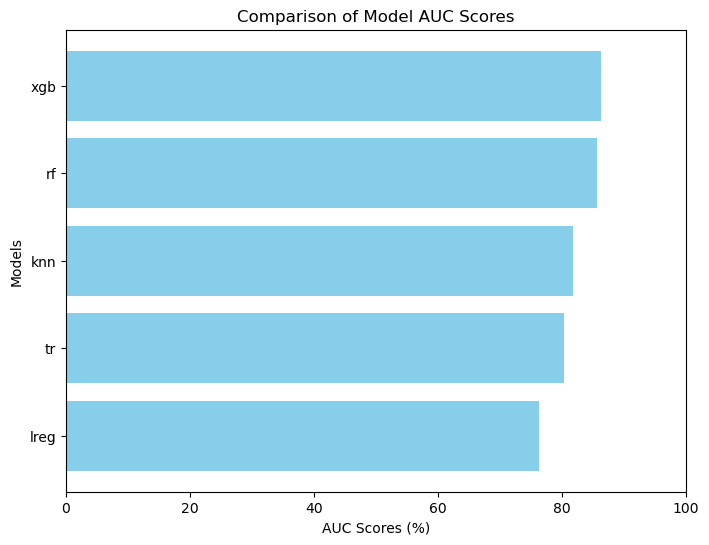

In [79]:
results = {
    "lreg": auc_lr,
    "xgb": auc_xgb,
    "knn": auc_knn,
    "rf": auc_rf,
    "tr": auc_dt
}

sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)

for i, (model, auc) in enumerate(sorted_results, 1):
    print(f"{i}. {model} = {auc}")

results_percentage = {model: score * 100 for model, score in sorted_results}

models = list(results_percentage.keys())
scores = list(results_percentage.values())

plt.figure(figsize=(8, 6))
plt.barh(models, scores, color='skyblue')
plt.xlabel('AUC Scores (%)')
plt.ylabel('Models')
plt.title('Comparison of Model AUC Scores')
plt.xlim(0, 100)
plt.gca().invert_yaxis()

## Conclution

By finetuning the models results are up 20% in general, to achieve this results the following features where added:

<b>5-Fold Cross-Validation</b> for a more robust 

<b>Grid Search</b> to cross validate hyperparameters and get the best performing parameters combination

<b>predict_proba</b> instead of predict for AUC-ROC calculation (internally used by gridsearch), using predict() loses information about the model's confidence, as it converts probabilities to binary decisions

